## Сравнение оптимизаторов и Dropout на сложных данных

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import warnings

warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Генерация сложного набора данных

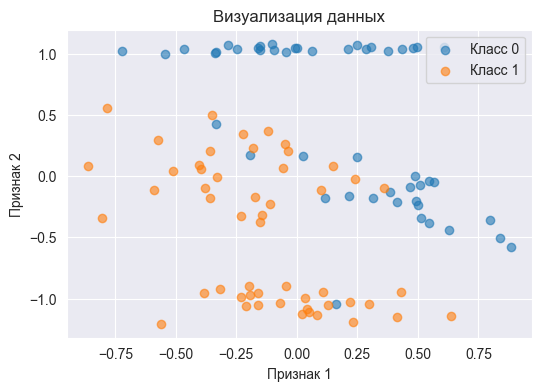

In [8]:
NUM_FEATURES = 100

X, y = make_classification(
    n_samples=100,
    n_features=NUM_FEATURES,
    n_informative=2,
    n_redundant=98,
    n_repeated=0,
    n_classes=2,
    flip_y=0.1,
    class_sep=0.6,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(6, 4))
plt.scatter(X[y==0, 0], X[y==0, 1], label="Класс 0", alpha=0.6)
plt.scatter(X[y==1, 0], X[y==1, 1], label="Класс 1", alpha=0.6)
plt.title("Визуализация данных")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.legend()
plt.show()

Предобработка данных

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)

Определение MLP с Dropout

In [11]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(dropout_prob)
        self.output = nn.Linear(16, 1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.act(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

Функция обучения и оценки модели

In [12]:
def run_training(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs=500):
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    for ep in range(epochs):
        # --- Обучение ---
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        preds_train = (outputs > 0.5).float()
        acc_train = (preds_train == y_train).float().mean()
        
        # --- Валидация ---
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            preds_val = (val_outputs > 0.5).float()
            acc_val = (preds_val == y_val).float().mean()
        
        # Сохраняем метрики
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_acc.append(acc_train.item())
        val_acc.append(acc_val.item())

    return train_losses, val_losses, train_acc, val_acc

Сравнение оптимизаторов без Dropout

In [13]:
optim_dict = {
    "SGD": optim.SGD,
    "Adam": optim.Adam,
    "RMSProp": optim.RMSprop
}

criterion = nn.BCELoss()
results_no_dropout = {}

for name, OptClass in optim_dict.items():
    model = DeepMLP(input_dim=NUM_FEATURES, dropout_prob=0.0)
    
    lr = 0.01 if name=="SGD" else 0.001
    optimizer = OptClass(model.parameters(), lr=lr)
    
    train_l, val_l, train_a, val_a = run_training(model, optimizer, criterion,
                                                  X_train, y_train, X_val, y_val)
    
    results_no_dropout[name] = {
        "train_loss": train_l,
        "val_loss": val_l,
        "train_acc": train_a,
        "val_acc": val_a
    }
    
    print(f"{name} | Train Acc: {train_a[-1]:.4f}, Val Acc: {val_a[-1]:.4f}")


SGD | Train Acc: 0.9143, Val Acc: 0.8333
Adam | Train Acc: 0.9857, Val Acc: 0.9000
RMSProp | Train Acc: 0.9429, Val Acc: 0.8667


Сравнение оптимизаторов с Dropout

In [14]:
results_with_dropout = {}

for name, OptClass in optim_dict.items():
    model = DeepMLP(input_dim=NUM_FEATURES, dropout_prob=0.5)
    
    lr = 0.01 if name=="SGD" else 0.001
    optimizer = OptClass(model.parameters(), lr=lr)
    
    train_l, val_l, train_a, val_a = run_training(model, optimizer, criterion,
                                                  X_train, y_train, X_val, y_val)
    
    results_with_dropout[name] = {
        "train_loss": train_l,
        "val_loss": val_l,
        "train_acc": train_a,
        "val_acc": val_a
    }
    
    print(f"{name} | Train Acc: {train_a[-1]:.4f}, Val Acc: {val_a[-1]:.4f}")


SGD | Train Acc: 0.7714, Val Acc: 0.7667
Adam | Train Acc: 0.9286, Val Acc: 0.8333
RMSProp | Train Acc: 0.9143, Val Acc: 0.8667


Визуализация результатов

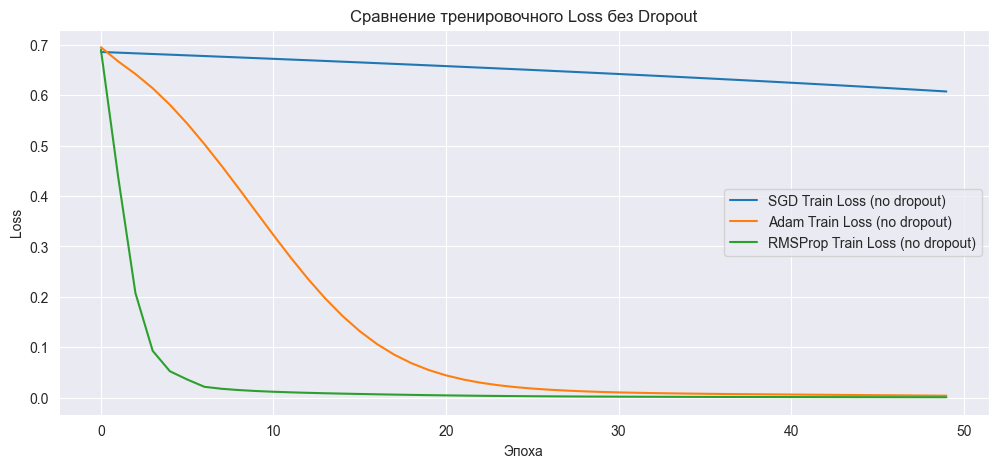

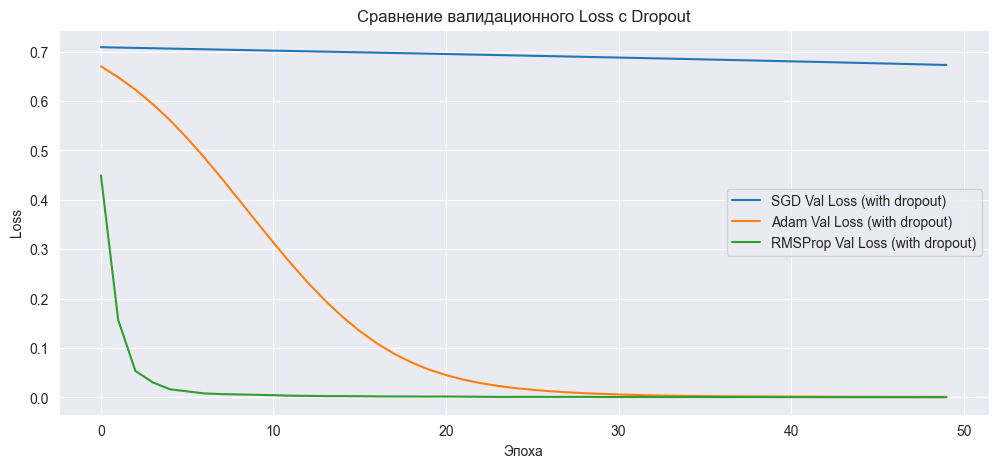

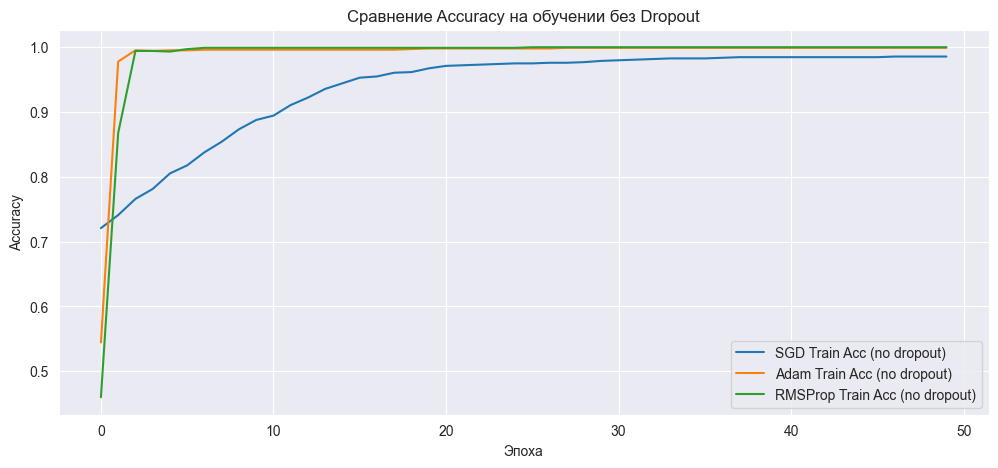

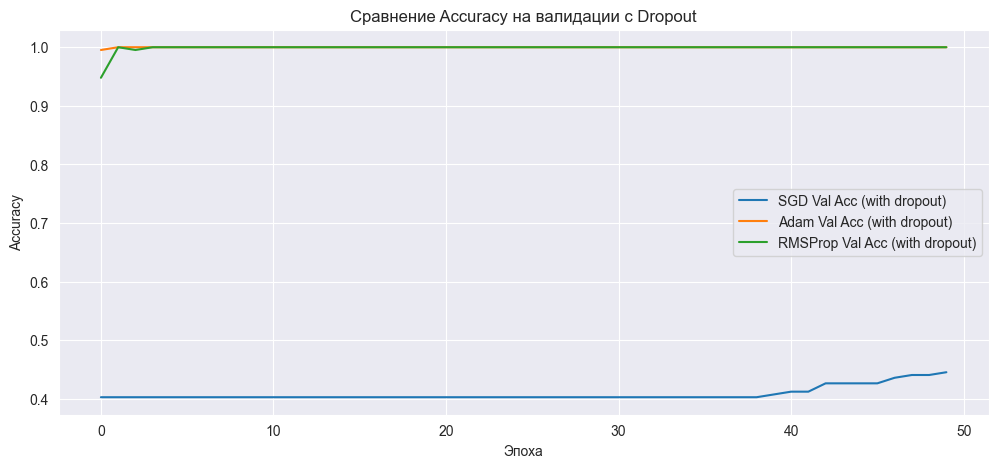

In [25]:
# Потери
plt.figure(figsize=(12, 5))
for name in optim_dict.keys():
    plt.plot(results_no_dropout[name]['train_loss'], label=f'{name} Train Loss (no dropout)')
plt.title("Сравнение тренировочного Loss без Dropout")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for name in optim_dict.keys():
    plt.plot(results_with_dropout[name]['val_loss'], label=f'{name} Val Loss (with dropout)')
plt.title("Сравнение валидационного Loss с Dropout")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(12, 5))
for name in optim_dict.keys():
    plt.plot(results_no_dropout[name]['train_acc'], label=f'{name} Train Acc (no dropout)')
plt.title("Сравнение Accuracy на обучении без Dropout")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for name in optim_dict.keys():
    plt.plot(results_with_dropout[name]['val_acc'], label=f'{name} Val Acc (with dropout)')
plt.title("Сравнение Accuracy на валидации с Dropout")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## Без Dropout
#### SGD 
Медленнее сходится, обучение более стабильное, меньше риск переобучения, но точность на тесте ниже.
#### Adam 
Быстрая сходимость, высокая точность на обучении, слегка склонен к переобучению. Хороший баланс скорости и качества
#### RMSProp
Быстрее, чем SGD, стабильнее, чем Adam. Хорошая точность на обучении, немного хуже на валидации

## С Dropout
#### SGD 
Обучение медленное, более стабильное, низкий риск переобучения
#### Adam 
Быстрая сходимость, высокая точность на обучении. Слегка склонен к переобучению, но обеспечивает хороший баланс скорости и качества
#### RMSProp
Скорость обучения между SGD и Adam, более стабильное обучение. Наилучшая среди оптимизаторов на валидации

    Для большинства современных задач оптимизаторы Adam и RMSProp с умеренным Dropout обеспечивают наилучшее сочетание скорости, стабильности и качества модели.

# Дополнительное задание: Многослойная нейронная сеть на MNIST

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Загрузка и подготовка данных MNIST

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data[:5000].numpy().reshape(-1, 28*28) / 255.0
y_train = train_dataset.targets[:5000].numpy()

X_test = test_dataset.data[:1000].numpy().reshape(-1, 28*28) / 255.0
y_test = test_dataset.targets[:1000].numpy()

mask_train = (y_train <= 1)
mask_test  = (y_test <= 1)

X_train, y_train = X_train[mask_train], y_train[mask_train]
X_test, y_test   = X_test[mask_test], y_test[mask_test]

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_test  = torch.FloatTensor(X_test)
y_test  = torch.FloatTensor(y_test).reshape(-1, 1)

print("Размер обучающего набора:", X_train.shape)
print("Размер тестового набора:", X_test.shape)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.84MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 168kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 288kB/s]

Размер обучающего набора: torch.Size([1042, 784])
Размер тестового набора: torch.Size([211, 784])


Определение MLP для MNIST

In [20]:
class MNIST_MLP(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(dropout_prob)
        self.output = nn.Linear(64, 1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

Функция обучения (как run_training)

In [21]:
def run_training_mnist(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs=100):
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    
    for ep in range(epochs):
        # --- Обучение ---
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        preds_train = (outputs > 0.5).float()
        acc_train = (preds_train == y_train).float().mean()
        
        # --- Валидация ---
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            preds_val = (val_outputs > 0.5).float()
            acc_val = (preds_val == y_val).float().mean()
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_acc.append(acc_train.item())
        val_acc.append(acc_val.item())
    
    return train_losses, val_losses, train_acc, val_acc

Исследование оптимизаторов на MNIST

In [22]:
optim_dict = {"SGD": optim.SGD, "Adam": optim.Adam, "RMSProp": optim.RMSprop}
criterion = nn.BCELoss()

results_no_dropout = {}
results_with_dropout = {}

for name, OptClass in optim_dict.items():
    # Без Dropout
    model = MNIST_MLP(input_dim=28*28, dropout_prob=0.0)
    lr = 0.01 if name=="SGD" else 0.001
    optimizer = OptClass(model.parameters(), lr=lr)
    
    train_l, val_l, train_a, val_a = run_training_mnist(model, optimizer, criterion,
                                                        X_train, y_train, X_test, y_test, epochs=50)
    results_no_dropout[name] = {"train_loss": train_l, "val_loss": val_l, "train_acc": train_a, "val_acc": val_a}
    print(f"{name} | Train Acc: {train_a[-1]:.4f}, Val Acc: {val_a[-1]:.4f}")
    
    # С Dropout
    model = MNIST_MLP(input_dim=28*28, dropout_prob=0.5)
    optimizer = OptClass(model.parameters(), lr=lr)
    
    train_l, val_l, train_a, val_a = run_training_mnist(model, optimizer, criterion,
                                                        X_train, y_train, X_test, y_test, epochs=50)
    results_with_dropout[name] = {"train_loss": train_l, "val_loss": val_l, "train_acc": train_a, "val_acc": val_a}
    print(f"{name} + Dropout | Train Acc: {train_a[-1]:.4f}, Val Acc: {val_a[-1]:.4f}")

SGD | Train Acc: 0.9856, Val Acc: 0.9905
SGD + Dropout | Train Acc: 0.5969, Val Acc: 0.4455
Adam | Train Acc: 0.9990, Val Acc: 1.0000
Adam + Dropout | Train Acc: 0.9990, Val Acc: 1.0000
RMSProp | Train Acc: 1.0000, Val Acc: 1.0000
RMSProp + Dropout | Train Acc: 1.0000, Val Acc: 1.0000


Визуализация результатов

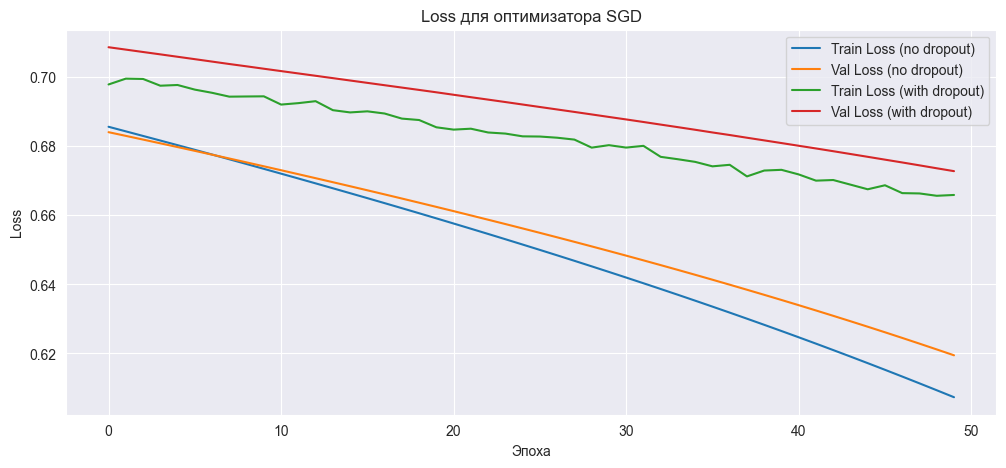

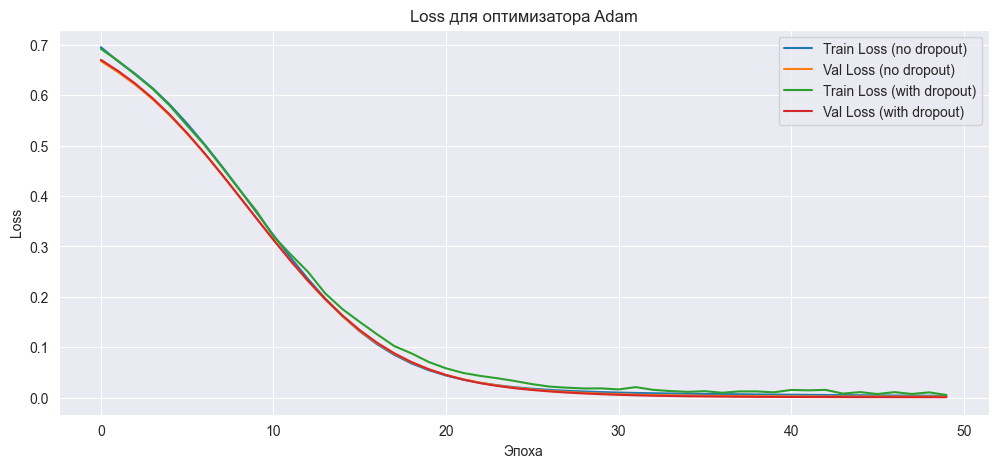

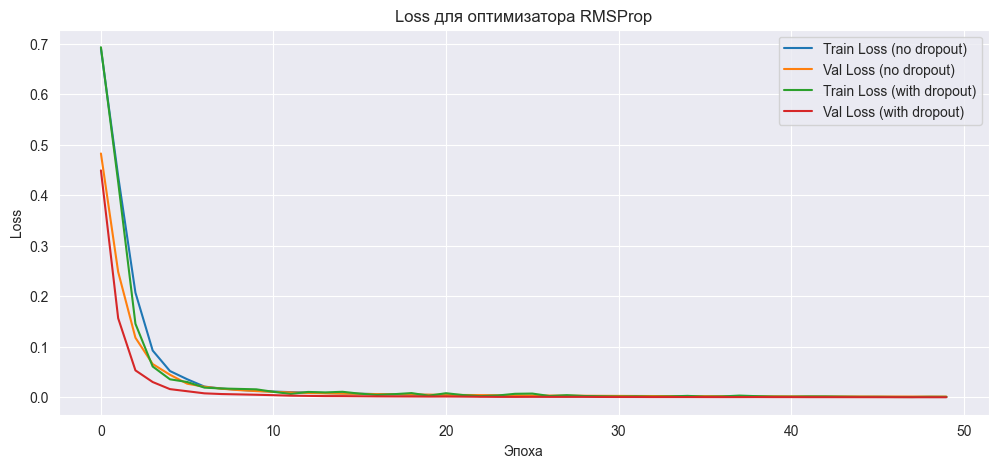

In [23]:
for name in optim_dict.keys():
    plt.figure(figsize=(12,5))
    plt.plot(results_no_dropout[name]['train_loss'], label='Train Loss (no dropout)')
    plt.plot(results_no_dropout[name]['val_loss'], label='Val Loss (no dropout)')
    plt.plot(results_with_dropout[name]['train_loss'], label='Train Loss (with dropout)')
    plt.plot(results_with_dropout[name]['val_loss'], label='Val Loss (with dropout)')
    plt.title(f"Loss для оптимизатора {name}")
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Без Dropout
#### SGD 
Обучение стабильное и точное, с высокой сходимостью. Модель показывает хорошую точность как на обучении, так и на валидации
#### Adam 
Очень быстрая сходимость, точность на обучении и валидации максимальная (почти идеальная). Оптимизатор эффективен для сложных данных и глубоких сетей.
#### RMSProp
Максимальная точность на обучении и валидации. Обучение стабильное и быстрое, модель полностью справляется с задачей классификации MNIST

## С Dropout
#### SGD 
Dropout сильно замедляет обучение и снижает точность, модель недообучается. Для медленных оптимизаторов регуляризация может оказаться слишком агрессивной.
#### Adam 
Dropout практически не влияет на результат, точность на обучении и валидации остаётся максимальной
#### RMSProp
Dropout не влияет на точность, обучение стабильно и эффективное, точность остаётся максимальной

    Для MNIST оптимизаторы Adam и RMSProp показывают максимальную эффективность, с Dropout или без него, обеспечивая быструю
     сходимость и идеальное качество модели. SGD стабильный, но чувствителен к регуляризации Dropout на сложных данных.